# Welcome to Pleiades! the python package for Plasma Experiment Iteratively Advanced Design and Simulation

#### The goal of this package is to make designing magnetic confinement experiments simple, intuitive and fast for the purpose of interfacing with advanced plasma physics codes like NIMROD, GENRAY, and CQL3D and optimization of design considerations.

#### There are 4 main sections to the code base that focus on the fundamental stages of experimental design. They are as follows:
1. An object oriented coil design architecture with built in Green's functions for axisymmetric field calculations and incorporated visulization
2. A simple MHD equilibrium solver
3. Preliminary stability calculations (m=1 flute mode and m=\inf ballooning) for magnetic mirrors
4. Integrated IO module for generating input files to other codes like eqdsks for GENRAY and CQL3D

#### This example notebook demonstrates how to use an existing experiment known as the Big Red Ball (BRB) located at the Wisconsin Plasma Physics Laboratory (WIPPL) and add an additional coil set to produce a non-paraxial magnetic mirror. A vacuum field geometry is selected and an equilibrium is computed for a given pressure profile. Finally an eqdsk compatible with GENRAY and CQL3D is generated. There are plots and explanations along the way to help you get your feet wet!

Necessary import section is shown below. Pleiades is designed to be compatible with an out-of-the-box installation of Anaconda2/3 and the primary dependencies are numpy/scipy and matplotlib. If part of this notebook doesn't work for you please let us know and we will try to get a fix in place as soon as possible!

In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
from pleiades.wipplsystems import BRB
from pleiades.helpers import *
from pleiades.grids import RectGrid
from pleiades.core import ZSymmCoilSet
from pleiades.math import get_gpsi
from pleiades.eq_solve import compute_equilibrium
from pleiades.io import write_eqdsk
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

Now we will start by creating our Experiment which is done by instantiating an object of the BRB class. We will add an extra coil set, set some coil current values and create a grid in the R-Z plane for the ensuing computations.

In [15]:
# create the BRB object
brb = BRB()

# add a mirror coil set by creating a Z-Symmetric coil set and adding it to the brb calling it "mirrors"
mirror_set = ZSymmCoilSet(r0=0.15,z0=0.55,nr=11,nz=5,dr=.01,dz=.01,fc=".35")
brb.add_component(mirror_set,"mirrors")

# choose values for TREX coil (2kA) and current in mirror coils to (100kA) and assign them
trex_cur = 2000
mir_cur = 100000
brb.trex.currents = [trex_cur,trex_cur]
brb.mirrors.currents = [mir_cur,mir_cur]

# turn off current in ltrx coils and in the vessel magnets so they don't mess with the flux plot
# also hide the visualization for the ltrx coils with brb.ltrx.patch_mask
brb.ltrx.currents = [0,0]
brb.vessel_mags.currents = [0,0,0]
brb.ltrx.patch_mask = [1,1]

# build the grid for field computation - creates a structured R-Z grid from R=[0,1] with 101 points and Z=[-.5,5] with 151 points
RZgrid = RectGrid((0,1,101),(-.5,.5,151))
R,Z = RZgrid.R, RZgrid.Z

# set the brb grid (does all greens functions calculations right here)
brb.grid = RZgrid

Here we will force the shape of the limiting flux surface by specifying the flux line through the mirror throat at (R,Z) = (0.08m,0.5m) to also pass through the point (R,Z) = (0.6m,0.0m). The mirror coil current is fixed and the TREX coil current is solved in order to enforce this criterion.

In [16]:
# force psi_lim through rlim1,zlim1 and rlim2,zlim2
rlim1,zlim1 = 0.08,0.5
rlim2,zlim2 = 0.6,0.0
r1idx,z1idx = np.abs(R[0,:]-rlim1).argmin(), np.abs(Z[:,0]-zlim1).argmin()
r2idx,z2idx = np.abs(R[0,:]-rlim2).argmin(), np.abs(Z[:,0]-zlim2).argmin()
gm1,gm2 = np.sum(brb.mirrors.gpsi,axis=-1).reshape(R.shape)[z1idx,r1idx], np.sum(brb.mirrors.gpsi,axis=-1).reshape(R.shape)[z2idx,r2idx]
gc1,gc2 = np.sum(brb.trex.gpsi,axis=-1).reshape(R.shape)[z1idx,r1idx], np.sum(brb.trex.gpsi,axis=-1).reshape(R.shape)[z2idx,r2idx]
gp1,gp2 = 0, 0
iplas = 0
new_trex_cur = -((gm1-gm2)*brb.mirrors.currents[0] + (gp1-gp2)*iplas)/(gc1 - gc2)
print(new_trex_cur)
brb.trex.currents = [new_trex_cur,new_trex_cur]

1955.2281046222972


Now we will try our hand at plotting some of this data as well as the visulaizations. to access the fields like psi, B_R, and B_Z we simply call their attributes from the brb object as shown below.

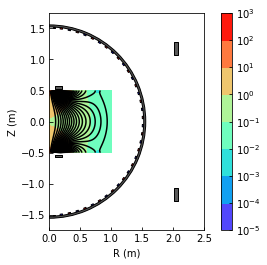

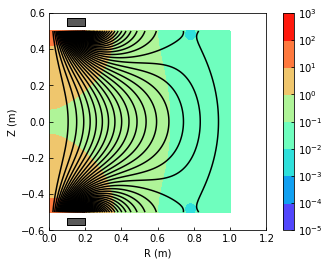

In [17]:
# get desired field quantities from brb object and view coilset
B = np.sqrt(brb.BR**2+brb.BZ**2)
BR = brb.BR
BZ = brb.BZ
psi = brb.psi
psi_lim = locs_to_vals(R,Z,psi,[(rlim1,zlim1)])[0]
psi_space = np.linspace(0,psi_lim,11)

# Plotting Section
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator())
ax.contour(R,Z,psi,51,colors="k")
plt.colorbar(cf)
ax.set_xlim(0,2.5)
ax.set_ylim(-1.75,1.75)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.set_aspect(1)
ax.add_collection(brb.patch_coll)
plt.show()

# Zoomed in Plotting Section
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator())
ax.contour(R,Z,psi,51,colors="k")
plt.colorbar(cf)
ax.set_xlim(0,1.2)
ax.set_ylim(-.6,.6)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.set_aspect(1)
ax.add_collection(brb.patch_coll)
plt.show()

Now lets look at an equilibrium... A few parameters are important here: name the plasma limiting radius, a, the peak pressure, P0, the exponent of the pressure profile, alpha, and the plasma beta at the origin with respect to the vacuum field. Once we build the pressure function and get the Green's function for plasma currents on the grid we are ready to run compute_equilibrium and write out an eqdsk. When this cell is run you should see the iteration number and error print to the screen and the error should decrease to a small value below 1E-10 by default to know the computation has converged.

pressure  34442.29835806626
computing gpsi blocks...
creating reflected block matrix
building huge matrix...
returning...
0
1
1
3.6922282304159055
2
0.0684575440549677
3
0.014266570899282596
4
0.000254316758911416
5
7.433515901017479e-05
6
1.2307944462279968e-06
7
4.0351002726984504e-07
8
6.533792507791154e-09
9
2.220822122243825e-09
10
3.683293224374093e-11


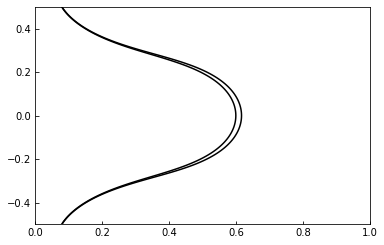

In [18]:
# setup pressure profile and compute P0 for a given desired initial beta
a = .6
alpha = 2.0
beta0 = .1
B0 = locs_to_vals(R,Z,B,[(0,0)])[0]
P0 = beta0*B0**2/(2*4*np.pi*1E-7)
print("pressure ", P0)
# build pressure function of cylindrical radius
Pfunc = lambda x: P0*(1-(x/a)**2)**alpha if x < a else 0
# get greens function for plasma currents
gplas = get_gpsi(R,Z)
# compute equilibrium
psieq,plas_currents,pfit = compute_equilibrium(R,Z,Pfunc,psi,gplas,maxiter=400,plotit=False)
write_eqdsk(R,Z,psi,plas_currents,"mfnpeqdsk1.txt","MFNP_Mirror Equilib")
P = pfit(psi.flatten()).reshape(psi.shape)
jphi = plas_currents/((R[0,1]-R[0,0])*(Z[1,0]-Z[0,0]))

Below we will plot some flux lines as well as the diamagnetic current density j_phi in A/m^2 in the colormap. We've also included a demonstration of tracing field lines which can be used to interpolate values along a field line for stability calculations as well as flux surface averaging.

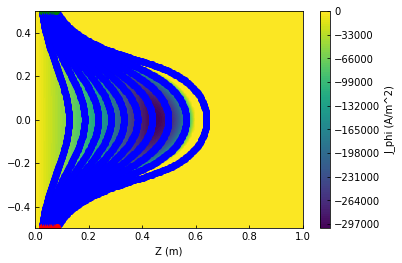

In [19]:
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,jphi,101)
cs = ax.contour(R,Z,psieq,psi_space,colors="k")
for clev in psi_space[1:]:
    flpts = get_fieldlines(cs,clev,start_coord=(0.05,.5),end_coord=(0.05,-0.5),clockwise=True)
    ax.plot(flpts[:,0],flpts[:,1],"bo")
    ax.plot(flpts[0,0],flpts[0,1],"go")
    ax.plot(flpts[-1,0],flpts[-1,1],"ro")
ax.set_xlabel("R (m)")
ax.set_xlabel("Z (m)")
cbar = fig.colorbar(cf)
cbar.set_label("J_phi (A/m^2)")
plt.show()

Here let's plot a slice of B along the axis of symmetry.

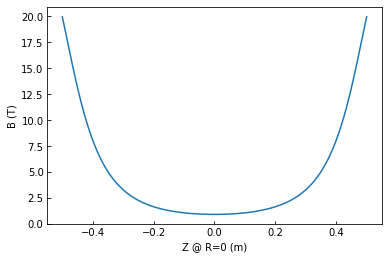

In [20]:
#### Plotting 
# plot slice of Bz as function of Z at R=0
ridx = np.abs(R[0,:]).argmin()
plt.plot(Z[:,ridx],B[:,ridx])
plt.xlabel("Z @ R=0 (m)")
plt.ylabel("B (T)")
plt.show()

Now let's look at how the flux lines change with finite plasma beta. the black lines are the vacuum field lines and green are the equilibrium field line values for the given beta and pressure profile.

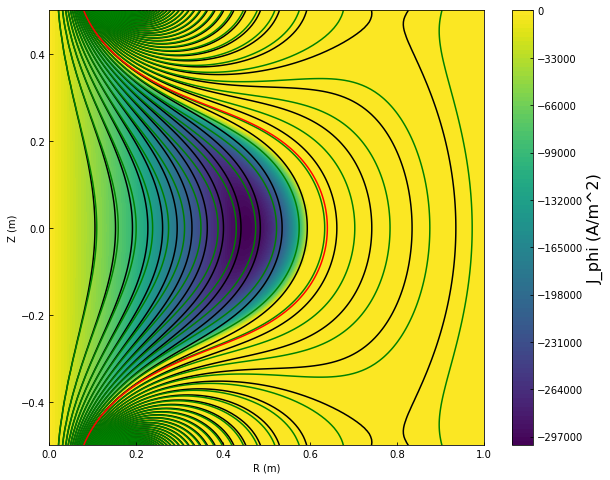

In [21]:
# plot up close flux lines and J_phi
fig,ax = plt.subplots(figsize=(10,8))
#cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator(),zorder=0)
cf = ax.contourf(R,Z,jphi,101,zorder=0)
cs = ax.contour(R,Z,psi,51,colors='k',lw=2,zorder=1)
cs1 = ax.contour(R,Z,psieq,51,colors='g',lw=2,zorder=1)
cs = ax.contour(R,Z,psieq,(psi_lim,),colors='r',lw=2,zorder=1)
cbar = fig.colorbar(cf)
cbar.set_label("J_phi (A/m^2)",fontsize=16)
ax.set_xlim(0,1.0)
ax.set_ylabel("Z (m)")
ax.set_xlabel("R (m)")
ax.set_ylim(-.5,.5)
ax.set_aspect('equal')
ax.add_collection(PatchCollection(brb.patches,match_original=True))
plt.show()